# Imports

#### General

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Tensorflow and NumPy

In [2]:
random_state = 1
import numpy as np
np.random.seed(random_state)
import random
random.seed(random_state)
import tensorflow
tensorflow.set_random_seed(random_state)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Sci-Kit Learn

In [3]:
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.metrics import mean_squared_error

#### Keras

In [4]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


#### Local

In [5]:
from util.genetic_evaluation import build_evaluation
from util.model_analysis import number_of_weights_in
from util.model_validation import validate
from evolve import *
from evolve.callbacks import *

# Data

In [6]:
train = pd.read_csv('../feature_engineering/train.gz')
X_train = train[train.columns[:-1]].values
y_train = train[train.columns[-1]].values

In [7]:
test = pd.read_csv('../feature_engineering/test.gz')
X_test = test[test.columns[:-1]].values
y_test = test[test.columns[-1]].values

# Models

In [8]:
rf = RandomForestRegressor(
    bootstrap=False, 
    criterion='mse', 
    max_depth=None,
    max_features='sqrt', 
    max_leaf_nodes=None,
    min_impurity_decrease=0.001, 
    min_impurity_split=None,
    min_samples_leaf=8, 
    min_samples_split=8,
    min_weight_fraction_leaf=0.0, 
    n_estimators=17, 
    n_jobs=1,
    oob_score=False, 
    random_state=random_state, 
    verbose=0, 
    warm_start=False
)
rf

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [9]:
br = BayesianRidge(
    alpha_1=1, 
    alpha_2=1, 
    compute_score=False, 
    copy_X=True,
    fit_intercept=True, 
    lambda_1=1, 
    lambda_2=1.0, 
    n_iter=1,
    normalize=False, 
    tol=0.001, 
    verbose=False
)
br

BayesianRidge(alpha_1=1, alpha_2=1, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1, lambda_2=1.0, n_iter=1,
       normalize=False, tol=0.001, verbose=False)

In [10]:
gb = GradientBoostingRegressor(
    alpha=0.9, 
    criterion='friedman_mse', 
    init=None,
    learning_rate=0.3, 
    loss='ls', 
    max_depth=10, 
    max_features=None,
    max_leaf_nodes=100, 
    min_impurity_decrease=0.2,
    min_impurity_split=None, 
    min_samples_leaf=9,
    min_samples_split=3, 
    min_weight_fraction_leaf=0.0,
    n_estimators=21, 
    presort='auto', 
    random_state=random_state,
    subsample=1.0, 
    verbose=0, 
    warm_start=False
)
gb

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=100, min_impurity_decrease=0.2,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=21, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

In [11]:
models = {
    rf.__class__.__name__: rf, 
    br.__class__.__name__: br, 
    gb.__class__.__name__: gb
}

#### Fit

In [12]:
for _, model in models.items():
    model.fit(X_train, y_train)

#### Predict

In [13]:
predictions = {name: model.predict(X_train) for (name, model) in models.items()}

In [14]:
train_df = pd.DataFrame(predictions)
train_df['Truth'] = y_train

In [15]:
train_df.head()

,BayesianRidge,GradientBoostingRegressor,RandomForestRegressor,Truth
0,9.769505,13.392991,14.763702,15.55904
1,9.102280,12.998163,13.856789,14.43644
2,7.467854,10.487035,12.983188,13.24040
3,7.063342,10.487035,13.138361,13.49220
4,7.807087,10.463812,13.663825,12.67385


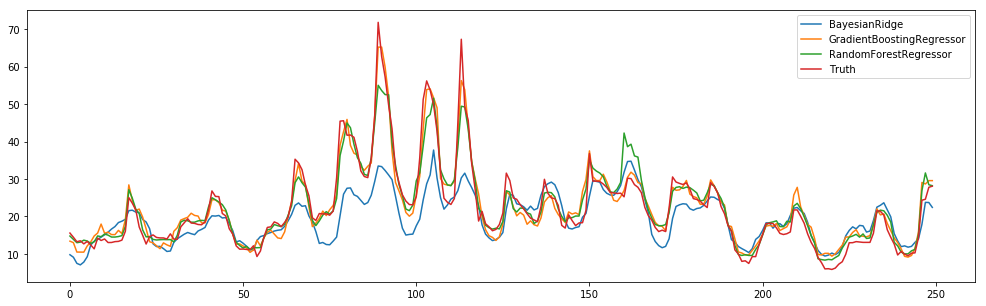

In [16]:
_ = train_df[:250].plot(figsize=(17, 5))

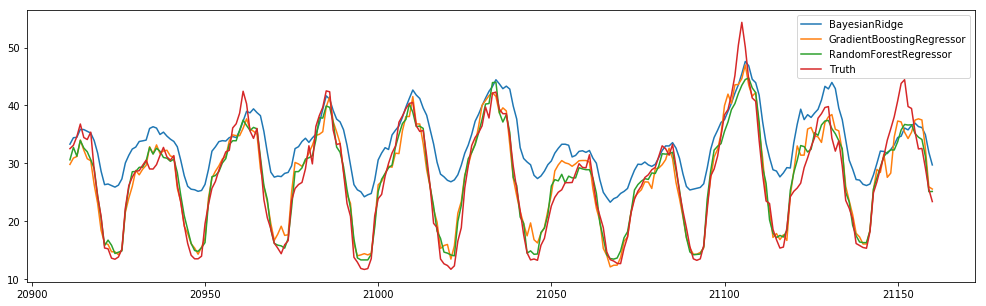

In [17]:
_ = train_df[-250:].plot(figsize=(17, 5))

#### Generate Error

In [18]:
error_df = (train_df.T - y_train.T).T
error_df.head()

,BayesianRidge,GradientBoostingRegressor,RandomForestRegressor,Truth
0,-5.789535,-2.166049,-0.795338,0.0
1,-5.334160,-1.438277,-0.579651,0.0
2,-5.772546,-2.753365,-0.257212,0.0
3,-6.428858,-3.005165,-0.353839,0.0
4,-4.866763,-2.210038,0.989975,0.0


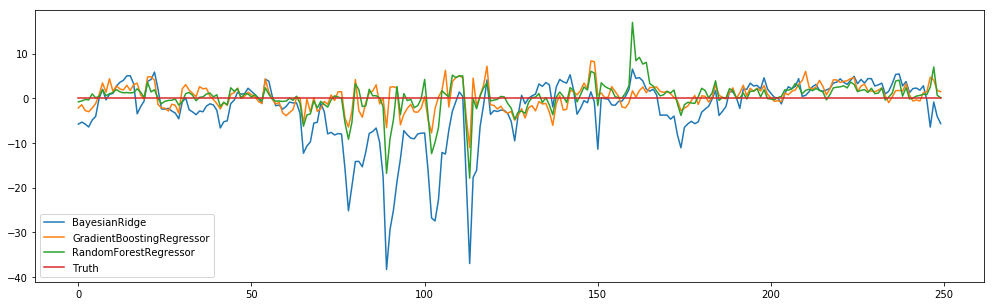

In [19]:
_ = error_df[:250].plot(figsize=(17, 5))

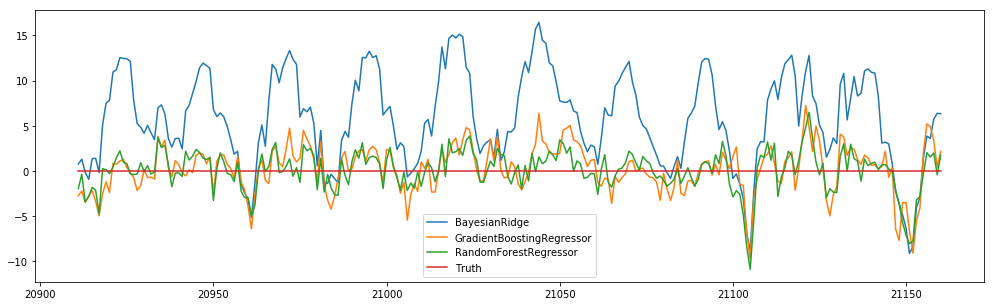

In [20]:
_ = error_df[-250:].plot(figsize=(17, 5))

#### Generate Predictive Model

##### 2 ideas

-   regress the actual error and use the model with the lowest predicted error (**not implemented here**)
-   for each time step, assign a label of 1 to the regressor with the lowest error (**implemented here**)

In [21]:
model_selector = error_df.copy()
del model_selector['Truth']

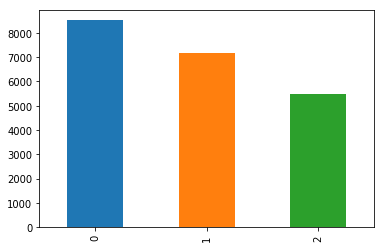

In [22]:
# calculate the column index of the model with the lowest error
min_errors = np.argmin(model_selector.values, axis=1)
_ = pd.Series(min_errors).value_counts().plot(kind='bar')

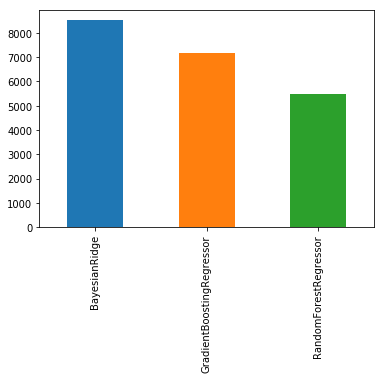

In [23]:
# zero out all the values
model_selector[:] = 0
# fancy index the values that should receive a label of 1
model_selector.values[range(len(model_selector)), min_errors] = 1
# plot the data to ensure the distribution is same as min_errors
_ = model_selector.sum().plot(kind='bar')

# Model Error

In [24]:
def build_model(
    input_dim: tuple=X_train.shape[1],
    output_dim: tuple=model_selector.shape[1],
) -> Model:
    """Build and compile a sequential Keras model (FFNN)."""
    # clear the Keras session to prevent out of memory error
    K.clear_session()
    # build the model
    model = Sequential([
        # Block 1
        Dense(32, input_dim=input_dim),
        Activation('relu'),
#         BatchNormalization(),
        Dropout(0.2),
        # Block 2
        Dense(16),
        Activation('relu'),
#         BatchNormalization(),
        Dropout(0.2),
        # Output Block
        Dense(output_dim),
        Activation('softmax'),
    ])
    # compile the model
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

#### Validate Simple Model

In [25]:
# validate(build_model(), X_train, model_selector.values)

In [26]:
# validate(build_model(), X_train, model_selector.values,
#     is_fitting=True,
#     epochs=2000, 
#     batch_size=10000,
# )

#### Genetic Optimization of Weights

In [27]:
# get_fitness = build_evaluation(build_model, X_train, model_selector.values)

In [28]:
get_fitness = build_evaluation(build_model, X_train, model_selector.values, 
    is_fitting=True,
    epochs=100,
    batch_size=10000,
)

In [29]:
factory = ChromosomeFactory(
    RealCodedChromosome, 
    number_of_weights_in(build_model()),
    evaluate=get_fitness,
    initial_state=(0, 1)
)
population = factory.population(5)

In [30]:
[ind.fitness for ind in population]

[0.3383583006516425,
 0.3383583006516425,
 0.3383583006516425,
 0.3383583006516425,
 0.4023439345966637]

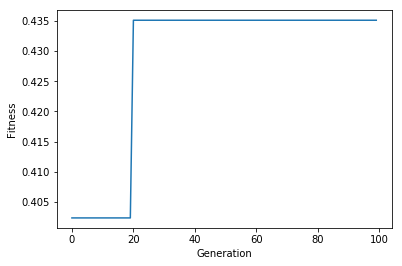

100%|██████████| 100/100 [13:44<00:00,  8.24s/iteration]


[0.43509285950569443,
 0.4023439345966637,
 0.4023439345966637,
 0.3383583006516425,
 0.4023439345966637]

In [31]:
ga = GeneticAlgorithm(
    LinearRankSelector(size=2, replace=False),
    NPointCrossoverProcreator(crossovers=2),
    RealCodedMutationProcreator(mutation_rate=0.2, random_state=(0, 1)),
    SteadyStateSurvivorSelector(size=2)
)
graph = EliteGraph(is_jupyter=True)
pop = ga.evolve(population, iterations=100, callback=graph)
[ind.fitness for ind in pop]